In [16]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [17]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [18]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [19]:
# build the dataset
# context length: how many characters do we take to predict the next one?
import random
block_size = 8


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [20]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [21]:
# Lego building blocks

# ---------------------------------------------------------------------------------------------------------------
class Linear:
    # fan_in = # of inputs
    # fan_out = # of outputs
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn(
            (fan_in, fan_out)) / fan_in**0.5  # kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
# ---------------------------------------------------------------------------------------------------------------


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum  # momentum determines how much to move the running mean/std
        # have diff behavior whether training or evaluation/inference mode
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)  # batch mean
            xvar = x.var(dim, keepdim=True)  # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        # normalize to unit variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        # custom field we make for plotting, pytorch will not have
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():  # trained exponential moving average in fwd pass only
                self.running_mean = (1 - self.momentum) * \
                    self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * \
                    self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
# ---------------------------------------------------------------------------------------------------------------


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []
# -----------------------------------------------------------------------------------------------


# Instead of
# C = torch.randn((vocab_size, n_embd), generator=g)
# emb = C[x]
class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]
# -----------------------------------------------------------------------------------------------


# Flattens n consecutive elements
class FlattenConsecutive:
    # take # of consecutive elems to concat
    def __init__(self, n) -> None:
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape  # (4, 8, 10) in the example
        # want to concat the embeddings of the n-grams together
        x = x.view(B, T//self.n, C*self.n)

        # If we are trying to group ALL 8 chars together than ok u have a vector of size 1, just return the element instead
        if x.shape[1] == 1:
            x = x.squeeze(dim=1)  # squeeze out first dim only

        self.out = x
        return self.out

    def parameters(self):
        return []
# -----------------------------------------------------------------------------------------------


class Sequential:

    def __init__(self, layers):
        self.layers = layers

    # Just call all layers sequentially
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [22]:
torch.manual_seed(42)  # global seed rng for reproducibility

In [23]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 68  # the number of neurons in the hidden layer of the MLP
model = Sequential([
    Embedding(vocab_size, n_embd),

    # Split into bigrams
    # Takes pairs of chars: (10 + 10) = 20 input dims -> 200 output dims
    # Output: [batch_size, 4 pairs, 200 hidden_dim]
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden,
                                  bias=False), BatchNorm1d(n_hidden), Tanh(),

    # Takes pairs of outputs: (200 + 200) = 400 input dims -> 200 output dims
    # Shape: [batch_size, 2 pairs, 200 hidden_dim]
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden,
                                  bias=False), BatchNorm1d(n_hidden), Tanh(),

    # Final pairs: (200 + 200) = 400 input dims -> 200 output dims
    # Shape: [batch_size, 1, 200 hidden_dim]
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden,
                                  bias=False), BatchNorm1d(n_hidden), Tanh(),




    Linear(n_hidden, vocab_size)
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1  # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

22397


In [24]:
model.layers[3].running_mean.shape

torch.Size([68])

In [26]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update: simple SGD
    lr = 0.1 if i < 150_000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        # Std dev of update / Std of actual data content
        # How great are the updates compared to tensors?
        # Then take log 10 so its nicer to visualize
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item()
                  for p in parameters])

    # if i >= 1000:
    #     break  # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 2.1474


In [246]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

AttributeError: 'Embedding' object has no attribute 'out'

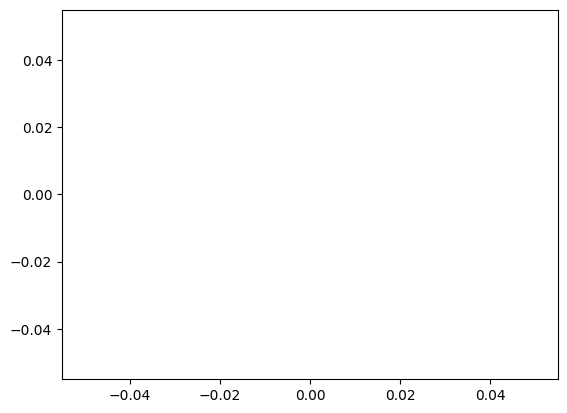

In [215]:
# This is better than just plotting lossi because it has a lot of noise bc of natural fluctuations in training loss between individual batches.
view_per_row_avg = torch.tensor(lossi).view(-1, 1000).mean(dim=1)
plt.plot(view_per_row_avg)

In [216]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [217]:
# evaluate the loss
@torch.no_grad()  # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss('train')
split_loss('val')

train 3.303192615509033
val 3.3028366565704346


In [218]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ['.','.','.']
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))  # decode and print the generated word

ggnlhsetujaimw.
pfeuifovktdiqzfvrgbeo.
odptdsxmhvvqmwdzawverslpfvgeubgwqzzgsmvdsnefi.
iqbuqv.
nb.
axtv.
rfvcnbotevowh.
bhatisgvvsfxwdipgkzmcg.
gnjlmcxffynjzleqfqkgmeschbbajosfd.
ebm.
eywkkuqtjagn.
gfuzogcyxcrmvtu.
tstmlgxjuluoisbwwsnswtcehttaibqgwlyabaajnildhcqsmepmypltesxinwinqogstvwblimecgjaxqpp.
dkgwusplskdoctefmtqkwxrfw.
dszixsxibgzaawuaufuzpchnjkzrzujlhslvsqbtfiwturvqtcu.
.
fufnqzbqzspdncivqzta.
wczsdrff.
knadsfsgqxfktp.
vsciqwhqtazwyjbsg.
